In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import vmap, jit
from fastprogress import progress_bar
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import bayes_ca.inference as core

## Simulate from the hierarchical model

In [2]:
key = jr.PRNGKey(0)

num_timesteps = 200
num_subjects = 2
max_duration = 100
hazard_prob = 0.01

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 0.5 * sigmasq_pri   # Note: variance of jump size is 2 * sigmasq_pri
# sigmasq_subj = 0.5**2   # Note: variance of jump size is 2 * sigmasq_pri
sigmasq_obs = 0.05**2

hazard_rates = hazard_prob * jnp.ones(max_duration + 1)
hazard_rates = hazard_rates.at[-1].set(1.0)

In [3]:
# First sample the global states
this_key, key = jr.split(key)
_, true_global_means = core.sample_gaussian_cp_model(key, num_timesteps, hazard_rates, mu_pri, sigmasq_pri)

# Sample means for each subject given the global mean
this_key, key = jr.split(key)
_sample_one = lambda key: core.gaussian_cp_posterior_sample(
    key, true_global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)

_, true_subj_means = vmap(_sample_one)(jr.split(this_key, num_subjects))

# Finally, sample observations for each subject
this_key, key = jr.split(key)
subj_obs = tfd.Normal(true_subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)


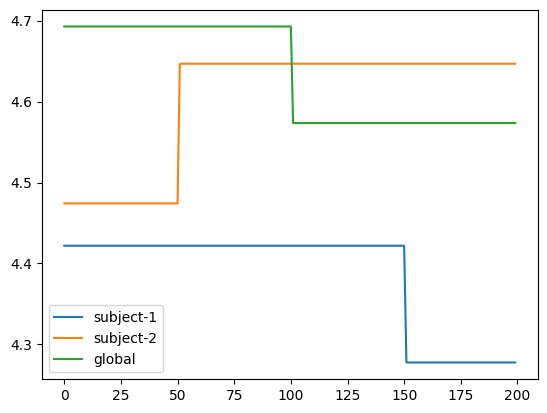

In [4]:
subject_seq = true_subj_means[0]
first_state, second_state = jnp.unique(subject_seq)
padding = jnp.repeat(second_state, 50)
rolled  = jnp.append(padding, subject_seq)[:200]
true_subj_one = rolled

subject_seq = true_subj_means[1]
first_state, second_state = jnp.unique(subject_seq)
padding = jnp.repeat(second_state, 50)
rolled  = jnp.append(subject_seq, padding)[50:]
true_subj_two = rolled

plt.plot(true_subj_one, label='subject-1')
plt.plot(true_subj_two, label='subject-2')
plt.plot(true_global_means, label='global')
plt.legend()

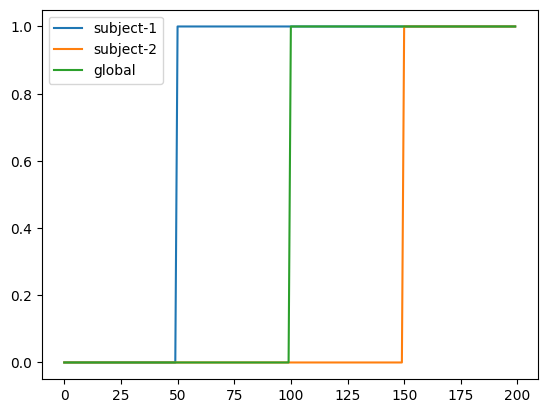

In [23]:
true_global_means = jnp.append(
    jnp.repeat(0.0, 100),
    jnp.repeat(1.0, 100)
)

true_subj_one = jnp.append(
    jnp.repeat(0.0, 50),
    jnp.repeat(1.0, 150)  
)
true_subj_two = jnp.append(
    jnp.repeat(0.0, 150),
    jnp.repeat(1.0, 50)  
)

plt.plot(true_subj_one, label='subject-1')
plt.plot(true_subj_two, label='subject-2')
plt.plot(true_global_means, label='global')
plt.legend()

In [24]:
true_subj_means = jnp.stack((true_subj_one, true_subj_two), axis=0)

# Finally, sample observations for each subject
this_key, key = jr.split(key)
subj_obs = tfd.Normal(true_subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)

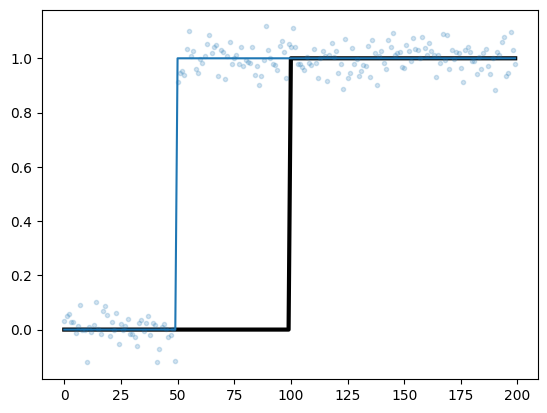

In [25]:
plt.plot(true_global_means, '-k', lw=3)
# plt.plot(subj_means.mean(axis=0))
# plt.plot(subj_obs.mean(axis=0))

for i in range(1):
    l = plt.plot(true_subj_means[i], alpha=1)[0]
    plt.plot(subj_obs[i], '.', color=l.get_color(), alpha=0.2)
# plt.xlim(0, 250)

## Sample conditional distribution for each subject

The effective observations for each subject are the weighted average of its observations and the global mean.

In [26]:
@jit
def gibbs_sample_subject_means(key,
                         subj_obs, 
                         sigmasq_obs, 
                         global_means, 
                         sigmasq_subj, 
                         mu_pri, 
                         sigmasq_pri, 
                         hazard_rates):
    num_subjects = subj_obs.shape[0]
    effective_sigmasq = 1 / (1 / sigmasq_obs + 1 / sigmasq_subj)
    effective_emissions = effective_sigmasq * (subj_obs / sigmasq_obs + global_means / sigmasq_subj)
    
    _sample_one = lambda key, y: core.gaussian_cp_posterior_sample(
        key, y, hazard_rates, mu_pri, sigmasq_pri, effective_sigmasq)[1]
    return vmap(_sample_one)(jr.split(key, num_subjects), effective_emissions)

In [27]:
key = jr.PRNGKey(0)
subj_means = gibbs_sample_subject_means(
    key, subj_obs, sigmasq_obs, true_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

In [28]:
subj_means.shape

(2, 200)

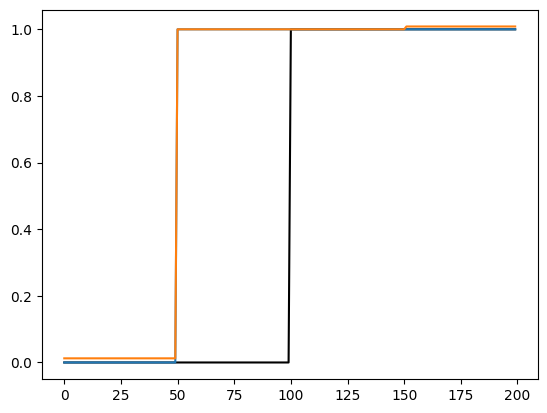

In [29]:
plt.plot(true_global_means, '-k')
plt.plot(true_subj_means[0])
plt.plot(subj_means[0])

## Compute gradient with respect to the global mean

In [30]:
@jit
def prox_update_global_mean(stepsize,
                            global_means,
                            subj_means, 
                            sigmasq_subj, 
                            mu_pri, 
                            sigmasq_pri, 
                            hazard_rates):
    # Use exponential family magic to compute gradient of the 
    # smooth part of the objective (not including the CP prior)
    _, _, _, expected_subj_means = core.gaussian_cp_smoother(
        global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)
    g = 1 / sigmasq_subj * jnp.sum(subj_means - expected_subj_means, axis=0)   # sum over subjects

    # Compute the proximal update by taking a step in the direction of the gradient
    # and using the posterior mode to find the new global states
    effective_emissions = global_means + stepsize * g
    return core.gaussian_cp_posterior_mode(
        effective_emissions, hazard_rates, mu_pri, sigmasq_pri, stepsize)[1]

In [31]:
stepsize = 0.001
global_means = jnp.zeros(num_timesteps)

for i in range(10000):
    global_means = prox_update_global_mean(
        stepsize, global_means, subj_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

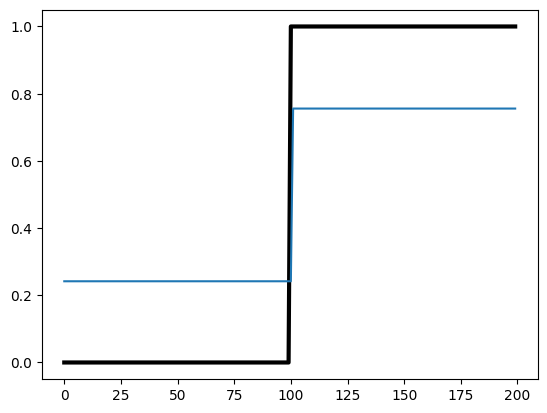

In [32]:
plt.plot(true_global_means, '-k', lw=3)
plt.plot(global_means)

## Put both steps together

In [33]:
@jit
def step(key,
         stepsize,
         subj_obs, 
         sigmasq_obs, 
         global_means, 
         sigmasq_subj, 
         mu_pri, 
         sigmasq_pri, 
         hazard_rates):
    
    # Sample new subject means
    subj_means = gibbs_sample_subject_means(
        key, subj_obs, sigmasq_obs, global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    
    # Update the global mean
    global_means = prox_update_global_mean(
        stepsize, global_means, subj_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    
    return global_means, subj_means

In [34]:
key = jr.PRNGKey(0)
stepsize = 0.001
global_means = jnp.zeros(num_timesteps)

for itr in progress_bar(range(10000)):
    this_key, key = jr.split(key)
    global_means, subj_means = step(
        this_key,
        stepsize,
        subj_obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )

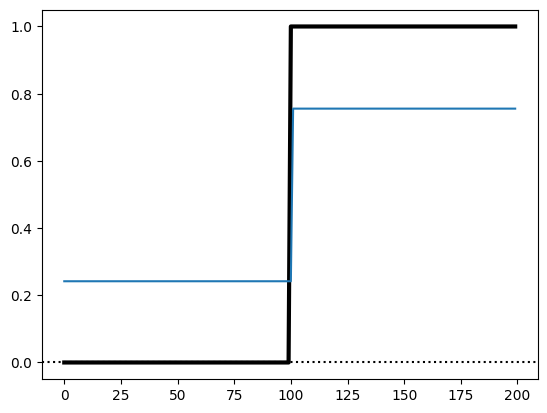

In [35]:
plt.plot(true_global_means, '-k', lw=3)
plt.plot(global_means)
plt.axhline(0, color='k', ls=':')

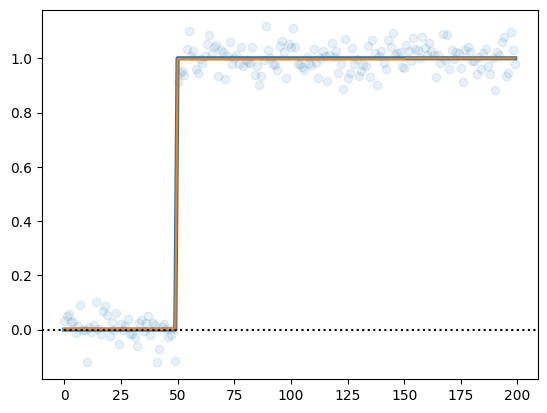

In [36]:
l = plt.plot(true_subj_means[0], lw=3)[0]
plt.plot(subj_obs[0], 'o', color=l.get_color(), alpha=0.1, lw=3)
plt.plot(subj_means[0])
plt.axhline(0, color='k', ls=':')

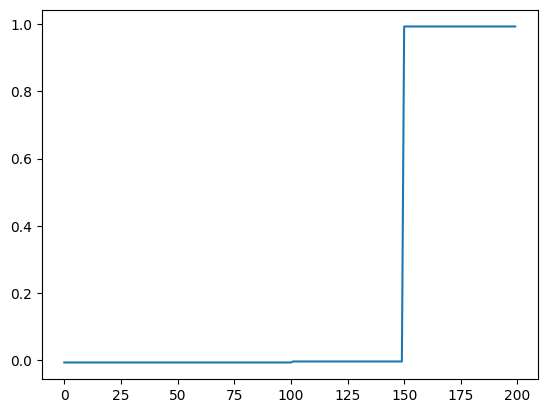

In [37]:
plt.plot(subj_means[1])